In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from visualizations.scripts.drawer import russia_plots
import sys
import pathlib
from copy import deepcopy

import xarray as xr
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from matplotlib import cm
from sklearn.cluster import SpectralClustering, KMeans, Birch, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.cluster import hierarchy

sys.path.append("/workspaces/my_dissertation")


def pca95(df: pd.DataFrame) -> np.ndarray:
    # scale_df = StandardScaler().fit_transform(df)
    scale_df = df
    pca_trans = PCA(n_components=0.95, random_state=42)
    pca_trans.fit(scale_df)

    reduced_df = pca_trans.transform(scale_df)

    return reduced_df


def get_high_silhoute(input_df: pd.DataFrame):
    clusters_range = range(2, 21)
    silhoute_result = dict()
    data = input_df
    for i in clusters_range:
        km = AgglomerativeClustering(n_clusters=i)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhoute_result[i] = silhouette_avg

    plt.rcParams["font.family"] = "Times New Roman"
    fig, ax = plt.subplots(figsize=(15, 8))

    x = list(silhoute_result.keys())
    y = list(silhoute_result.values())

    ax.plot(x, y, "-")
    line_x = x[np.argmax(y)]
    ax.axvline(x=line_x, color="r")

    ax.set_xlabel("Количество кластеров, шт.", fontsize=14)
    ax.set_ylabel("Величина силуэта", fontsize=14)
    ax.set_title(
        f"Максимальная величина силуэта найдена для {line_x} кластеров", fontsize=14
    )
    ax.xaxis.set_major_locator(ticker.FixedLocator(locs=[i for i in range(1, 21)]))
    ax.set_xticklabels([f"{i}" for i in range(1, 21)])

    plt.setp(ax.get_yticklabels(), fontsize=10)
    plt.setp(ax.get_xticklabels(), fontsize=10)
    ax.grid(False)
    plt.show()

    return fig


def lim_definer(area: float):
    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return "< 100 $км^2$"
    elif (area >= lim_1) & (area <= lim_2):
        return "100 $км^2$ - 2 000 $км^2$"
    elif (area > lim_2) & (area <= lim_3):
        return "2 000 $км^2$ - 10 000 $км^2$"
    elif (area > lim_3) & (area <= lim_4):
        return "10 000 $км^2$ - 50 000 $км^2$"
    else:
        return "> 50 000 $км^2$"

### Read and prepare geometry

In [4]:
gauges_file = gpd.read_file("../geo_data/geometry/russia_gauges.gpkg")
gauges_file["gauge_id"] = gauges_file["gauge_id"].astype(str)
gauges_file = gauges_file.set_index("gauge_id")

ws_file = gpd.read_file("../geo_data/geometry/russia_ws.gpkg")
ws_file = ws_file.set_index("gauge_id")
ws_file["size"] = ws_file.loc[:, "new_area"].apply(lambda x: lim_definer(x))
ws_file["size"] = pd.Categorical(
    ws_file["size"],
    [
        "< 100 $км^2$",
        "100 $км^2$ - 2 000 $км^2$",
        "2 000 $км^2$ - 10 000 $км^2$",
        "10 000 $км^2$ - 50 000 $км^2$",
    ],
)
ws_file = ws_file[ws_file["new_area"] <= 50000]

basemap_data = gpd.read_file("../geo_data/geometry/basemap_2023.gpkg")

basin_districts = gpd.read_file("../geo_data/geometry/basin_districts.gpkg")
basin_districts = basin_districts.reset_index(drop=True)
# fixed umgs shapes
basin_districts = basin_districts.reindex(
    [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        26,
        10,
        11,
        12,
        27,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        9,
        13,
    ]
)
basin_districts = basin_districts.reset_index(drop=True)
basin_districts = basin_districts.rename(columns={"BAS_OKRUG": "name1"})

### Read static data

In [9]:
# static_attrs = pd.read_csv("../geo_data/attributes/static_with_height.csv")
static_attrs = pd.read_csv("../geo_data/static_data.csv")
static_attrs["gauge_id"] = static_attrs["gauge_id"].astype(str)
static_attrs = static_attrs.set_index("gauge_id")
# adjust indexes in accordancew to size of data
ws_file = ws_file.loc[ws_file.index.isin(static_attrs.index), :]
static_attrs = static_attrs.loc[static_attrs.index.isin(ws_file.index), :]

# static_parameters = [
#     "for_pc_sse",
#     "crp_pc_sse",
#     "inu_pc_ult",
#     "ire_pc_sse",
#     "lka_pc_use",
#     "prm_pc_sse",
#     "pst_pc_sse",
#     "cly_pc_sav",
#     "slt_pc_sav",
#     "snd_pc_sav",
#     "kar_pc_sse",
#     "urb_pc_sse",
#     "gwt_cm_sav",
#     "lkv_mc_usu",
#     "rev_mc_usu",
#     "ws_area",
#     "ele_mt_sav",
# ]

# static_attrs = static_attrs[static_parameters]

static_cluster_data = deepcopy(static_attrs)
static_cluster_data = static_cluster_data.dropna()

static_cluster_data.loc[:, :] = StandardScaler().fit_transform(
    static_cluster_data.values
)

pca_vals = pca95(static_cluster_data)
static_pca = pd.DataFrame(
    columns=[f"pc_{i}" for i in range(pca_vals.shape[1])],
    index=static_cluster_data.index,
)
static_pca.index.name = "gauge_id"
static_pca.loc[:, :] = pca_vals

### Build correlation matrix for parameters

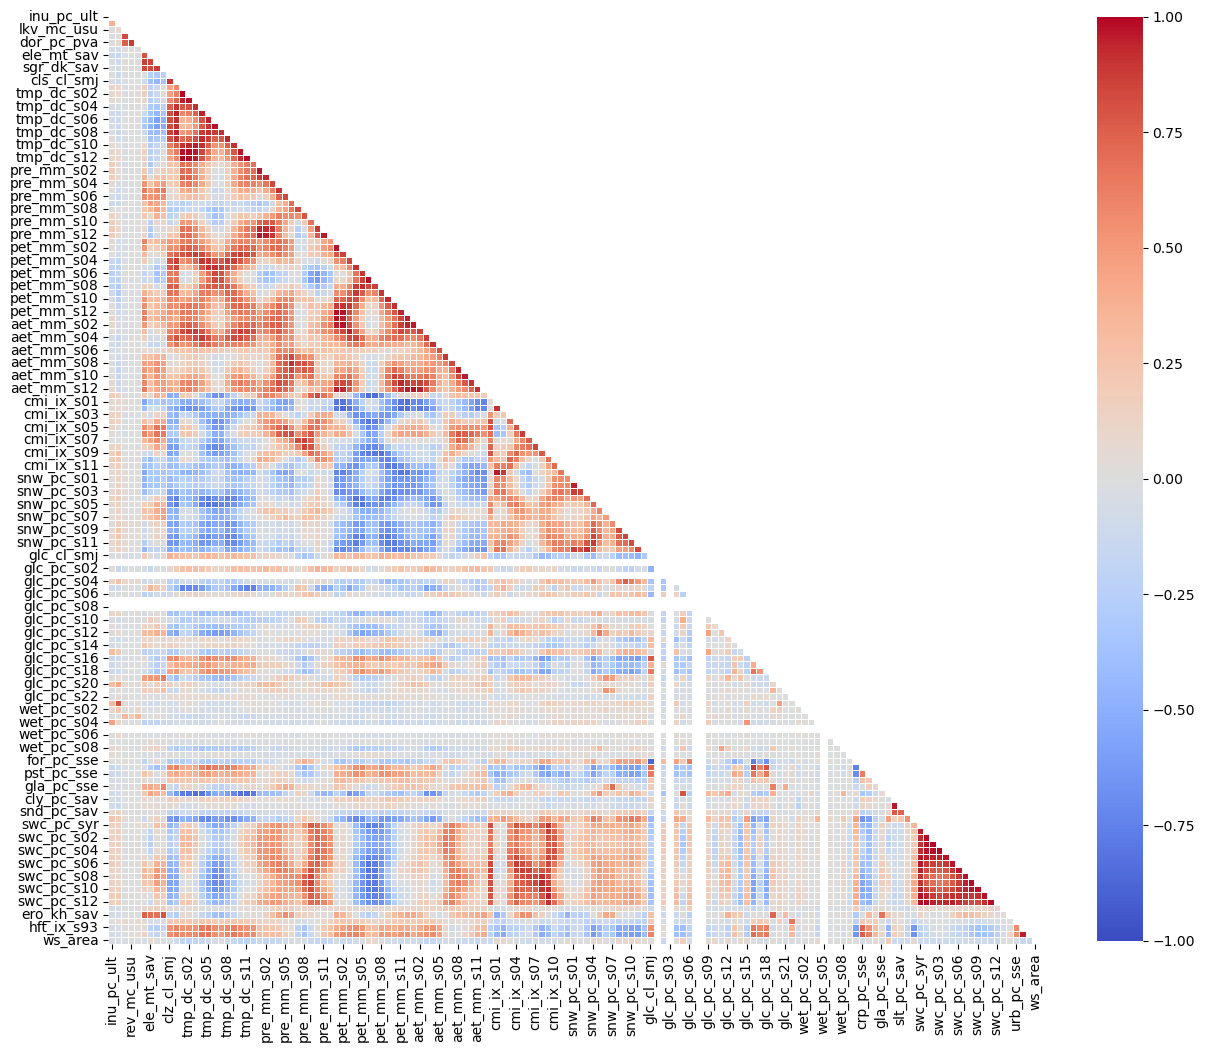

In [15]:
correlation_matrix = static_cluster_data.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool)
)
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    ax=ax,
    robust=True,
    vmax=1.0,
    vmin=-1.0,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)

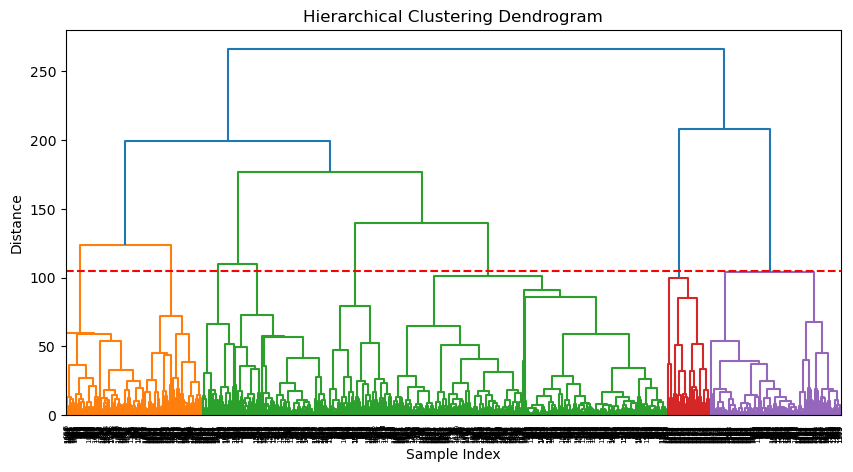

In [29]:
# Perform hierarchical clustering
Z = hierarchy.linkage(
    pca_vals, method="ward"
)  # You can use different linkage methods like 'single', 'complete', 'average', etc.

# Plot the hierarchical clustering dendrogram
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z)
# Draw a horizontal line to determine the number of clusters
threshold = 105  # Adjust this threshold as needed
plt.axhline(y=threshold, color="r", linestyle="--")

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

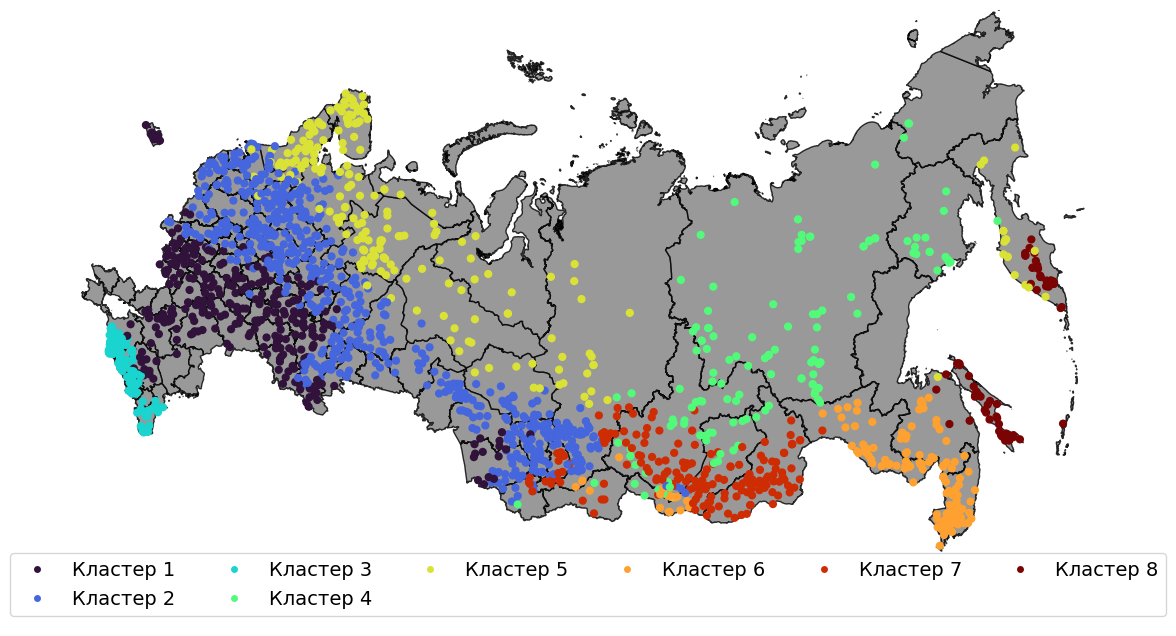

In [28]:
number_of_clusters = 8

# cluster_alg = SpectralClustering(
#     n_clusters=number_of_clusters,
#     random_state=42,
#     # affinity="rbf",
#     assign_labels="kmeans",
#     n_neighbors=static_pca.__len__() // number_of_clusters,
# )
# cluster_alg = KMeans(n_clusters=number_of_clusters, random_state=42)
cluster_alg = AgglomerativeClustering(
    n_clusters=number_of_clusters, linkage="ward", compute_full_tree=True
)

yhat_AC = cluster_alg.fit_predict(static_pca)
static_pca["ResClust"] = [i + 1 for i in yhat_AC]

gauges_file["ResClust"] = np.NaN
static_attrs["ResClust"] = np.NaN

gauges_file = gauges_file.combine_first(static_pca).dropna()
static_attrs = static_attrs.combine_first(static_pca).dropna()
gauges_file["Кластер"] = [f"Кластер {int(i)}" for i in gauges_file["ResClust"]]

gauges_fig = russia_plots(
    gdf_to_plot=gauges_file,
    basemap_data=basemap_data,
    distinction_col="Кластер",
    cmap_name="turbo",
    #   metric_col='Кластер',
    list_of_limits=list(range(1, 5)),
    figsize=(15, 8),
    just_points=True,
    with_histogram=False,
)

In [30]:
for i, idx in static_pca.groupby("ResClust").groups.items():
    print(f"для {i} нашлось {len(idx)} объектов")

для 1 нашлось 292 объектов
для 2 нашлось 613 объектов
для 3 нашлось 97 объектов
для 4 нашлось 133 объектов
для 5 нашлось 213 объектов
для 6 нашлось 145 объектов
для 7 нашлось 173 объектов
для 8 нашлось 71 объектов


### Clusters based on streamflow

In [24]:
available_gauges = list(
    i.stem
    for i in pathlib.Path("../geo_data/ws_related_meteo/nc_all_q/").glob("*.nc")
    if i.stem in ws_file.index
)

In [25]:
average_q_df = pd.DataFrame()

for gauge_id in available_gauges:
    with xr.open_dataset(f"../geo_data/ws_related_meteo/nc_all_q/{gauge_id}.nc") as f:
        yearly_file = f.to_dataframe()
        yearly_average = (
            yearly_file[["q_mm_day"]]
            .groupby([yearly_file.index.month, yearly_file.index.day])
            .mean()
            .values.ravel()
        )

    average_q_df.loc[:, gauge_id] = yearly_average
average_q_df = average_q_df.loc[:, average_q_df.max() < 100]

/tmp/ipykernel_65388/1296143286.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  average_q_df.loc[:, gauge_id] = yearly_average
/tmp/ipykernel_65388/1296143286.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  average_q_df.loc[:, gauge_id] = yearly_average
/tmp/ipykernel_65388/1296143286.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fr

In [65]:
q_df_clust = deepcopy(average_q_df.T)
q_df_clust.columns = q_df_clust.columns.astype(str)

gauges_clust = deepcopy(gauges_file)
for gauge_id in q_df_clust.index:
    for i in range(10):
        q_df_clust.loc[gauge_id,
                       f"lat_{i}"] = gauges_clust.loc[gauge_id, "geometry"].x
        q_df_clust.loc[gauge_id,
                       f"lon_{i}"] = gauges_clust.loc[gauge_id, "geometry"].y
q_df_clust = q_df_clust.copy()
# q_df_clust.loc[:, :] = MinMaxScaler().fit_transform(q_df_clust.values)

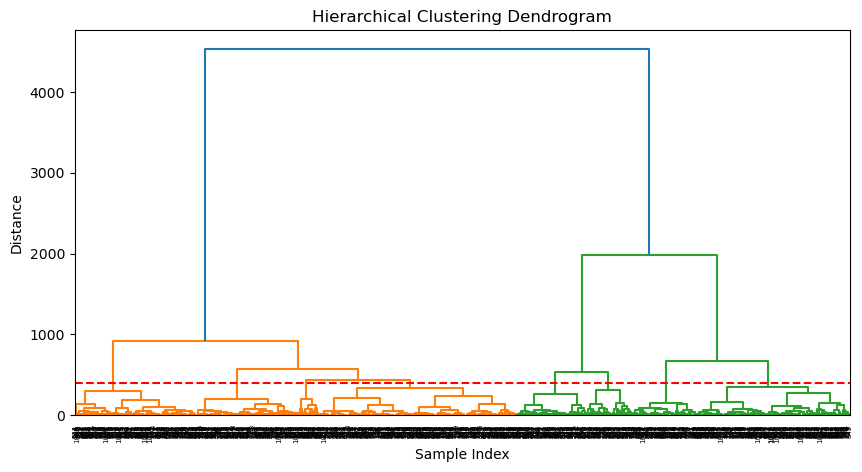

In [77]:
# Perform hierarchical clustering
Z = hierarchy.linkage(
    q_df_clust.values, method="ward"
)  # You can use different linkage methods like 'single', 'complete', 'average', etc.

# Plot the hierarchical clustering dendrogram
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z)
# Draw a horizontal line to determine the number of clusters
threshold = 400  # Adjust this threshold as needed
plt.axhline(y=threshold, color="r", linestyle="--")

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

для 1 нашлось 112 объектов
для 2 нашлось 92 объектов
для 3 нашлось 43 объектов
для 4 нашлось 25 объектов
для 5 нашлось 85 объектов
для 6 нашлось 49 объектов
для 7 нашлось 69 объектов
для 8 нашлось 21 объектов
для 9 нашлось 83 объектов
для 10 нашлось 67 объектов
для 11 нашлось 34 объектов
для 12 нашлось 27 объектов
для 13 нашлось 66 объектов
для 14 нашлось 63 объектов
для 15 нашлось 70 объектов
для 16 нашлось 50 объектов
для 17 нашлось 55 объектов
для 18 нашлось 5 объектов


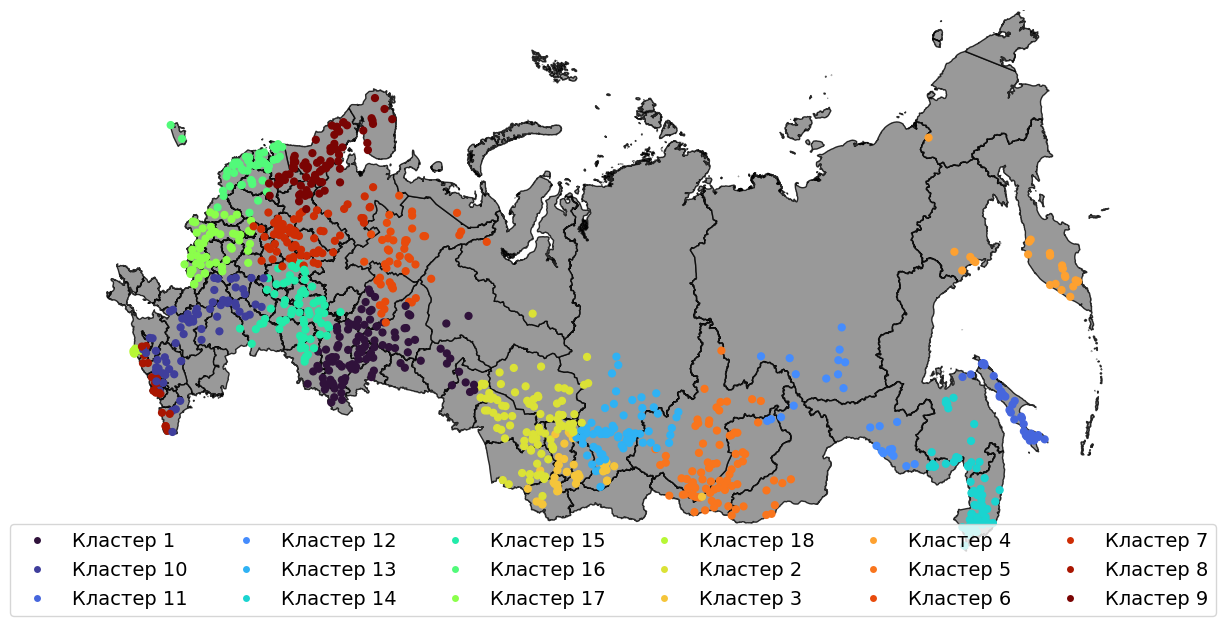

In [79]:
number_of_clusters = 18
cluster_alg = AgglomerativeClustering(
    n_clusters=number_of_clusters, linkage="ward", compute_full_tree=True
)
# cluster_alg = KMeans(n_clusters=number_of_clusters, random_state=42)


yhat_AC = cluster_alg.fit_predict(q_df_clust)
q_df_clust["ResClust"] = [i + 1 for i in yhat_AC]
bad_clusters = list()
for i, idx in q_df_clust.groupby("ResClust").groups.items():
    print(f"для {i} нашлось {len(idx)} объектов")
    if len(idx) < 5:
        bad_clusters.append(i)

q_df_clust = q_df_clust.loc[~q_df_clust["ResClust"].isin(bad_clusters), :]


gauges_clust["ResClust"] = np.NaN

gauges_clust = gauges_clust.combine_first(q_df_clust).dropna()
gauges_clust["Кластер"] = [f"Кластер {int(i)}" for i in gauges_clust["ResClust"]]

gauges_fig = russia_plots(
    gdf_to_plot=gauges_clust,
    basemap_data=basemap_data,
    distinction_col="Кластер",
    cmap_name="turbo",
    #   metric_col='Кластер',
    list_of_limits=list(range(1, number_of_clusters)),
    figsize=(15, 8),
    just_points=True,
    with_histogram=False,
)

In [326]:
q_df_clust.loc[~q_df_clust["ResClust"].isin(bad_clusters), :]

,0,1,2,3,4,5,6,7,8,9,...,lon_5,lat_6,lon_6,lat_7,lon_7,lat_8,lon_8,lat_9,lon_9,ResClust
75402,-0.038383,-0.038659,-0.038688,-0.038672,-0.038784,-0.038936,-0.039063,-0.038893,-0.038725,-0.038754,...,0.187596,-0.977257,0.187596,-0.977257,0.187596,-0.977257,0.187596,-0.977257,0.187596,2
9283,-0.038596,-0.038578,-0.038593,-0.038554,-0.038630,-0.038806,-0.038971,-0.038967,-0.038867,-0.039075,...,-0.266563,0.566605,-0.266563,0.566605,-0.266563,0.566605,-0.266563,0.566605,-0.266563,3
3210,-0.044239,-0.044143,-0.044033,-0.043966,-0.044060,-0.044405,-0.044710,-0.044655,-0.044366,-0.044720,...,1.201891,1.538571,1.201891,1.538571,1.201891,1.538571,1.201891,1.538571,1.201891,4
72102,-0.022373,-0.023215,-0.024094,-0.024524,-0.024744,-0.024388,-0.023546,-0.024293,-0.025301,-0.025806,...,1.256942,-1.111206,1.256942,-1.111206,1.256942,-1.111206,1.256942,-1.111206,1.256942,1
76486,-0.043102,-0.043018,-0.042923,-0.042862,-0.042931,-0.043221,-0.043479,-0.043422,-0.043159,-0.043460,...,-0.026489,-0.463320,-0.026489,-0.463320,-0.026489,-0.463320,-0.026489,-0.463320,-0.026489,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039,-0.040651,-0.040598,-0.040560,-0.040497,-0.040603,-0.040855,-0.041080,-0.041072,-0.040923,-0.041203,...,-0.418266,0.949061,-0.418266,0.949061,-0.418266,0.949061,-0.418266,0.949061,-0.418266,3
8288,-0.044133,-0.044036,-0.043927,-0.043858,-0.043952,-0.044295,-0.044597,-0.044539,-0.044254,-0.044602,...,0.833886,0.734319,0.833886,0.734319,0.833886,0.734319,0.833886,0.734319,0.833886,4
71277,-0.032527,-0.032592,-0.032637,-0.032639,-0.032681,-0.032625,-0.032580,-0.032633,-0.032708,-0.032800,...,2.453965,-1.063277,2.453965,-1.063277,2.453965,-1.063277,2.453965,-1.063277,2.453965,1
19382,-0.043141,-0.043063,-0.042980,-0.042909,-0.042990,-0.043298,-0.043565,-0.043501,-0.043241,-0.043557,...,-0.521454,-0.437235,-0.521454,-0.437235,-0.521454,-0.437235,-0.521454,-0.437235,-0.521454,2


In [328]:
q_df_clust["ResClust"]

75402    3
9283     2
3210     5
72102    1
76486    3
        ..
7039     2
8288     5
71277    1
19382    3
70466    1
Name: ResClust, Length: 1022, dtype: int64